### Notebook décrivant la fusion des données pour la régression des facteurs estimés

In [204]:
#environnement


import pandas as pd

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
import os

### Formattage données:

Les facteurs ston ceux du milieu du mois (2ème mercredi)

Les données éco/politiques datent du début du mois ou de la fin du mois précédent



### Etude des données de Nick Bloom

In [205]:
###Récupérer données Nick Bloom:

# Load the Excel file
file_path = 'data_regression/Europe_Policy_Uncertainty_Data (1).xlsx'
data_NB = pd.read_excel(file_path, engine='openpyxl')
# Drop the last line of the data
data_NB = data_NB[:-1]
# Print the last value of the column "Year"
print("Last year in the data:", data_NB['Year'].iloc[-1])

# Create a new column that indicates the date of each line as the first day of each month
data_NB['Date'] = pd.to_datetime(data_NB[['Year', 'Month']].assign(DAY=1)) 

data_NB.set_index('Date', inplace=True)

print("DOnnées NB brutes")
print(data_NB.tail())

Last year in the data: 2025
DOnnées NB brutes
            Year  Month  European_News_Index  Germany_News_Index  \
Date                                                               
2024-09-01  2024    9.0           345.050957          699.766418   
2024-10-01  2024   10.0           392.077152          871.019902   
2024-11-01  2024   11.0           479.988726         1095.932766   
2024-12-01  2024   12.0           484.420012          984.385100   
2025-01-01  2025    1.0           463.534694          942.147182   

            Italy_News_Index  UK_News_Index  France_News_Index  \
Date                                                             
2024-09-01        110.579817     303.677826         436.405581   
2024-10-01        100.498001     388.310662         322.289241   
2024-11-01        124.806529     396.505948         486.844264   
2024-12-01        133.739942     409.251621         567.708852   
2025-01-01         98.461246     458.899347         563.138944   

            Sp

Maintenant qu'on a récupéré les données mesurant l'instabilité politique, on étudie la stationnarité et l'autocorrélation de la série temporelle à partir de 2010 (dates des autres variables:
Min date: 2010-04-01 00:00:00
Max date: 2024-12-01 00:00:00).


On obtient des données peu autocorrélées pour la France (0.55), pour laquelle on peut rejetter l'hypothèse de non stationarité avec une grande confiance. Pas besoin donc ici de prendre les différences premières.

On différencie tout de même car on s'intérêrre à l'effet des variations d'instabilité, aux "nouvelles".

In [206]:
#calcul de l'autoccorrélation des données de Nick Bloom

data_NB_copy = data_NB[data_NB.index >=np.datetime64("2010-01-01")].copy()
autocorrelations = data_NB_copy.apply(lambda col: col.autocorr() if col.dtype in [np.float64, np.int64] else None)

# Print autocorrelation values
print("Autocorrelation données brutes NB post 2010:")
print(autocorrelations)

Autocorrelation données brutes NB post 2010:
Year                        NaN
Month                  0.538462
European_News_Index    0.776889
Germany_News_Index     0.916924
Italy_News_Index       0.536853
UK_News_Index          0.724163
France_News_Index      0.556503
Spain_News_Index       0.349930
dtype: float64


In [207]:
#on extrait uniquement les colonnes d'intérêt:

data_NB_FR = data_NB[['France_News_Index','European_News_Index']].copy()

In [208]:
#étude de la stationnarité des données de Nick Bloom

#conduct a test of stationarity on the factors:
from statsmodels.tsa.stattools import adfuller

for column in data_NB_copy.columns:
    print(f"Testing stationarity for {column}:")
    result = adfuller(data_NB_copy[column])
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)


Testing stationarity for Year:
p-value for Year: 0.9363133189857433
--------------------------------------------------
Testing stationarity for Month:
p-value for Month: 0.0
--------------------------------------------------
Testing stationarity for European_News_Index:
p-value for European_News_Index: 0.5545263051331276
--------------------------------------------------
Testing stationarity for Germany_News_Index:
p-value for Germany_News_Index: 0.9734523285792774
--------------------------------------------------
Testing stationarity for Italy_News_Index:
p-value for Italy_News_Index: 5.249630075815198e-05
--------------------------------------------------
Testing stationarity for UK_News_Index:
p-value for UK_News_Index: 0.05169048535212092
--------------------------------------------------
Testing stationarity for France_News_Index:
p-value for France_News_Index: 3.3448868087884857e-09
--------------------------------------------------
Testing stationarity for Spain_News_Index:
p-v

In [209]:
#On calcule l'indice de NB différencié

data_NB_diff = data_NB_FR.diff().dropna()
print(data_NB_diff.head)

<bound method NDFrame.head of             France_News_Index  European_News_Index
Date                                              
1987-02-01          -9.637027            -7.866753
1987-03-01          37.288947            30.439154
1987-04-01         -20.116167           -16.420928
1987-05-01         -19.319329           -15.770465
1987-06-01          29.672936            24.222166
...                       ...                  ...
2024-09-01          65.620110            81.622711
2024-10-01        -114.116339            47.026195
2024-11-01         164.555022            87.911574
2024-12-01          80.864589             4.431286
2025-01-01          -4.569909           -20.885319

[456 rows x 2 columns]>


### Etude des facteurs

Forme des données : (924, 10)
            factor 1  factor 2  factor 3  factor 4  factor 5  factor 6  \
Date                                                                     
2007-01-03  0.037039  0.038993  0.037558  0.035665  0.034280  0.033354   
2007-01-10  0.037892  0.039719  0.038157  0.036410  0.034866  0.033904   
2007-01-17  0.038122  0.039644  0.038197  0.037140  0.035543  0.033932   
2007-01-24  0.038143  0.039481  0.038021  0.037002  0.035261  0.033325   
2007-01-31  0.038668  0.039800  0.037851  0.037035  0.036100  0.034062   

            factor 7  factor 8  factor 9  factor 10  
Date                                                 
2007-01-03  0.032688  0.027748  0.023478   0.029683  
2007-01-10  0.033995  0.028913  0.023632   0.030361  
2007-01-17  0.034354  0.029508  0.023600   0.030247  
2007-01-24  0.033655  0.029092  0.023517   0.029767  
2007-01-31  0.034212  0.029708  0.023751   0.030343  
monthly data
            factor 1  factor 2  factor 3  factor 4  factor 5

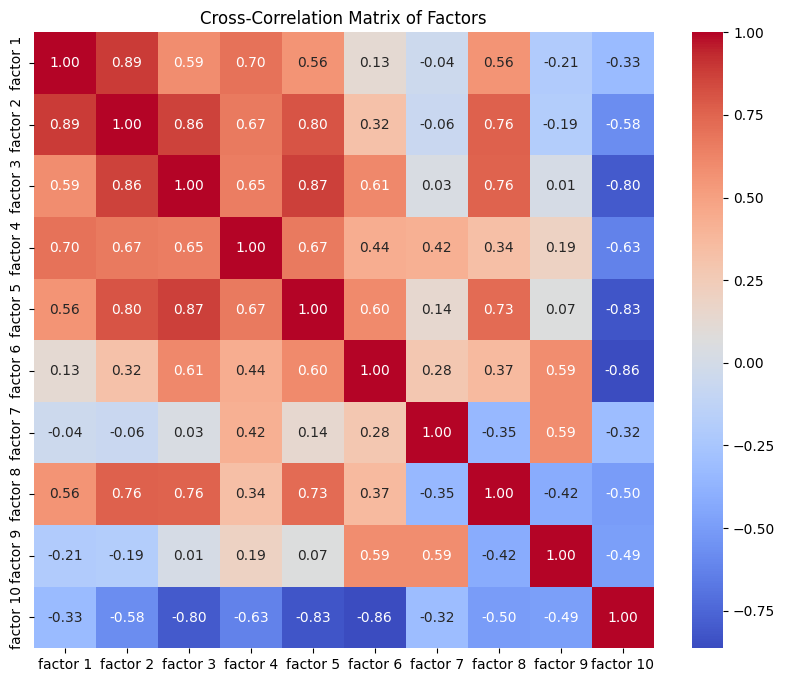

In [210]:
###Récupérer Facteurs:


# Lire les données depuis le fichier texte
array_factors = np.loadtxt('data_regression/mu_dd_CANFCPv2_FS10_31.txt')

# Vérifier la forme des données
print("Forme des données :", array_factors.shape)  # Doit afficher (nombre_de_lignes, 10)

# Créer la variable temps sous forme de dates
start_date = datetime.date(2007, 1, 3)
dates = np.array([start_date + datetime.timedelta(weeks=i) for i in range(array_factors.shape[0])])

# Convertir les dates en indices pour la régression linéaire
temps = np.arange(array_factors.shape[0]).reshape(-1, 1)  # [0, 1, 2, ..., n-1]

data_factors=pd.DataFrame(array_factors)
data_factors['Date']= dates
data_factors['Date']=pd.to_datetime(data_factors['Date'])

data_factors.set_index('Date', inplace=True)

data_factors.columns = [f"factor {i+1}" for i in range(10)]



print(data_factors.head())


#scaler les valeurs des facteurs (*100):

data_factors.iloc[:,:] = data_factors.iloc[:,:] * 100

## reindexer pour avoir des facteurs mensuels:

data_factors_mensuel = data_factors.resample('MS').first()

print("monthly data")
print(data_factors_mensuel.tail())


### Ici on étudie les données utilisées plus tard pour les régressions:

#data_factors_copy2 est utilisé pour étudier les facteurs
data_factors_copy2 = data_factors_mensuel[data_factors_mensuel.index >= np.datetime64("2009-12-01")]
# Calculate autocorrelation for each factor
autocorrelations = data_factors_copy2.apply(lambda col: col.autocorr() if col.dtype in [np.float64, np.int64] else None)



import seaborn as sns
# Calculate the cross-correlation matrix
correlation_matrix = data_factors_copy2.corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cross-Correlation Matrix of Factors")
plt.show()


Autocorrelation of factors:
factor 1     0.990618
factor 2     0.990028
factor 3     0.953252
factor 4     0.958481
factor 5     0.982729
factor 6     0.985774
factor 7     0.980528
factor 8     0.979442
factor 9     0.988406
factor 10    0.992178
dtype: float64


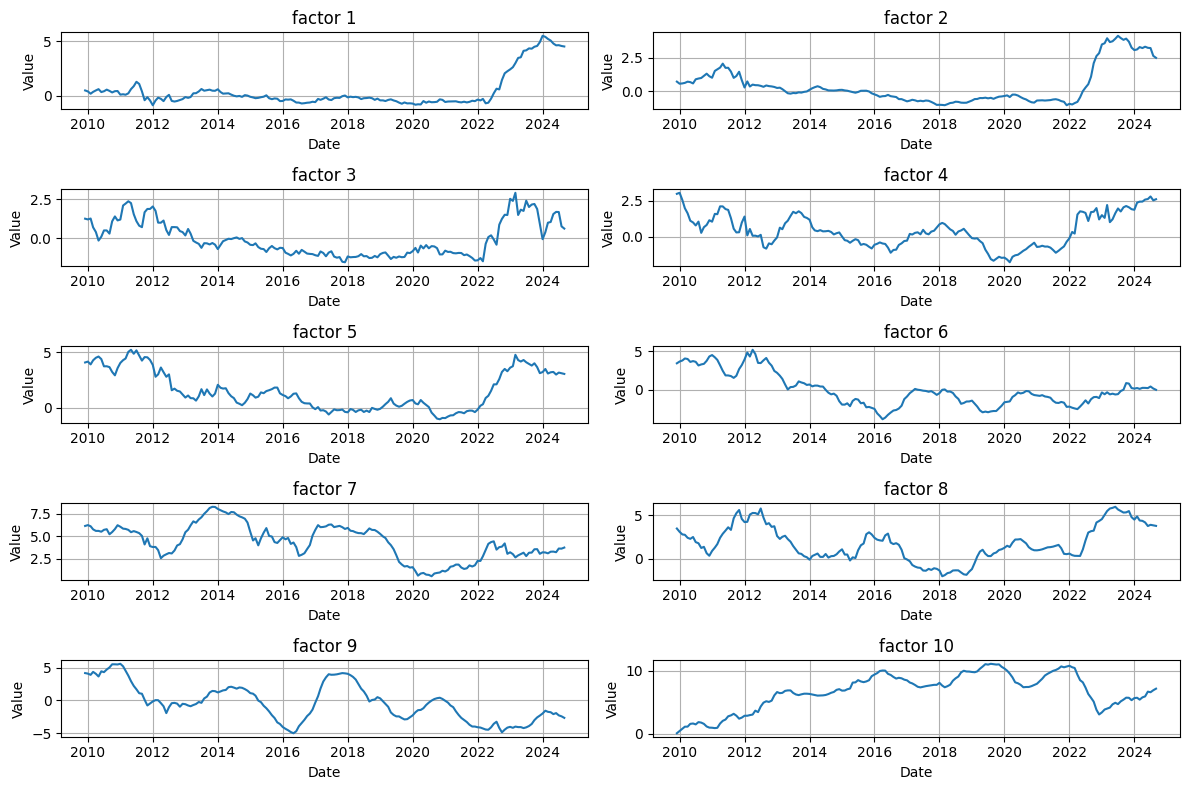

In [211]:
# Calculate autocorrelation for each factor (only numeric columns)
numeric_columns = data_factors_copy2.select_dtypes(include=[np.number])
autocorrelations = numeric_columns.apply(lambda col: col.autocorr())

# Print autocorrelation values
print("Autocorrelation of factors:")
print(autocorrelations)


# Plot the factors
plt.figure(figsize=(12, 8))
for i, column in enumerate(data_factors_copy2.columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(data_factors_copy2[column])
    plt.title(column)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
plt.tight_layout()
plt.show()

On teste ensuite la stationarité. On ne peut pas rejeter l'hypothèse de non stationarité pour la grande majorité des facteurs

In [212]:
#conduct a test of stationarity on the factors:
from statsmodels.tsa.stattools import adfuller

for column in data_factors_copy2.columns:
    print(f"Testing stationarity for {column}:")
    result = adfuller(data_factors_copy2[column])
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)

Testing stationarity for factor 1:
p-value for factor 1: 0.7640120169454006
--------------------------------------------------
Testing stationarity for factor 2:
p-value for factor 2: 0.41884867442007356
--------------------------------------------------
Testing stationarity for factor 3:
p-value for factor 3: 0.27184341407794377
--------------------------------------------------
Testing stationarity for factor 4:
p-value for factor 4: 0.1917367871178856
--------------------------------------------------
Testing stationarity for factor 5:
p-value for factor 5: 0.32950465298526527
--------------------------------------------------
Testing stationarity for factor 6:
p-value for factor 6: 0.17851461899894555
--------------------------------------------------
Testing stationarity for factor 7:
p-value for factor 7: 0.23649367924944437
--------------------------------------------------
Testing stationarity for factor 8:
p-value for factor 8: 0.3926434777376134
------------------------------

On décide donc d'étudier les premières différences des facteurs, qui devraient être stationnaires

In [213]:
data_factors_diff=data_factors_copy2.diff().dropna()
# Conduct a test of stationarity on each factor after differencing
for column in data_factors_diff.columns:
    print(f"Testing stationarity for {column} after differencing:")
    result = adfuller(data_factors_diff[column])
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)

Testing stationarity for factor 1 after differencing:
p-value for factor 1: 0.009881760168388917
--------------------------------------------------
Testing stationarity for factor 2 after differencing:
p-value for factor 2: 0.0051042451039870615
--------------------------------------------------
Testing stationarity for factor 3 after differencing:
p-value for factor 3: 0.006463232736106389
--------------------------------------------------
Testing stationarity for factor 4 after differencing:
p-value for factor 4: 3.267911430482606e-12
--------------------------------------------------
Testing stationarity for factor 5 after differencing:
p-value for factor 5: 5.905007856098662e-08
--------------------------------------------------
Testing stationarity for factor 6 after differencing:
p-value for factor 6: 5.811126173413728e-16
--------------------------------------------------
Testing stationarity for factor 7 after differencing:
p-value for factor 7: 4.400963218431514e-09
----------

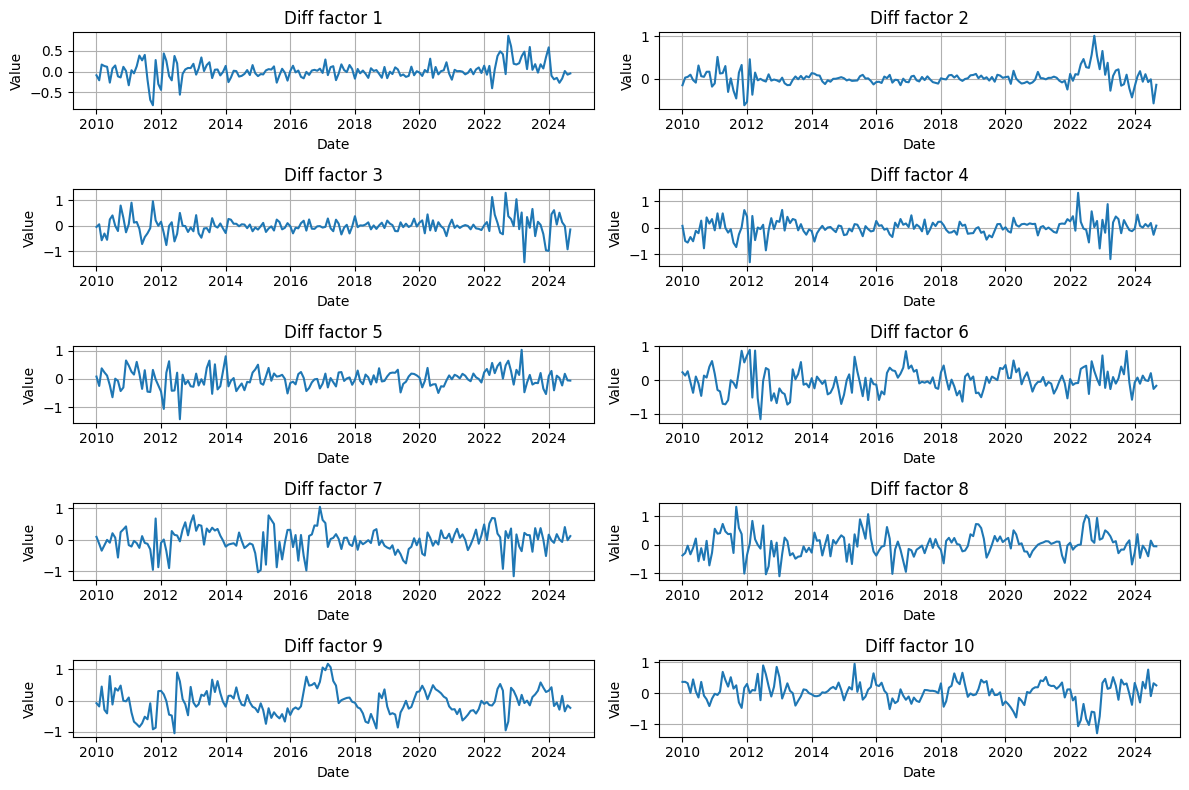

In [214]:
#plot the factors after differencing:
plt.figure(figsize=(12, 8))
for i, column in enumerate(data_factors_diff.columns, 1):
    plt.subplot(5, 2, i)
    plt.plot(data_factors_diff[column])
    plt.title(f"Diff {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [215]:
#On vérifie ensuite si les facteurs différenciés sont autocorrélés:
for column in data_factors_diff.columns:
    autocorr = data_factors_diff[column].autocorr()
    print(f"{column}: {autocorr}")

factor 1: 0.23270639742231722
factor 2: 0.3110878914161837
factor 3: 0.03164662210364091
factor 4: -0.05234142382788989
factor 5: 0.07318176770550781
factor 6: 0.3265043715651523
factor 7: 0.2122821006886522
factor 8: 0.31007914482655435
factor 9: 0.6108341030786978
factor 10: 0.5252498490680619


In [216]:
#on produit enfin une table qui résume les données de data_factors_diff en indiquant leur autocorrélation et leurs statistique de Dickey Fuller:
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
# Compute summary statistics
summary_factors_diff = data_factors_diff.copy()
summary_stats_factors_diff = summary_factors_diff.describe().T

# Add autocorrelation column
summary_stats_factors_diff['autocorrelation'] = summary_factors_diff.apply(
    lambda col: col.autocorr() if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Add Dickey-Fuller test p-value column
summary_stats_factors_diff['dickey_fuller_pvalue'] = summary_factors_diff.apply(
    lambda col: adfuller(col)[1] if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Format for markdown or text reports
formatted_table_factordiff = tabulate(summary_factors_diff, headers="keys", tablefmt="github")

print(summary_stats_factors_diff.to_latex(index=True, float_format="%.3f", caption="Summary Statistics with Autocorrelation and Dickey-Fuller Test"))

\begin{table}
\caption{Summary Statistics with Autocorrelation and Dickey-Fuller Test}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max & autocorrelation & dickey_fuller_pvalue \\
\midrule
factor 1 & 177.000 & 0.023 & 0.210 & -0.807 & -0.085 & 0.014 & 0.115 & 0.857 & 0.233 & 0.010 \\
factor 2 & 177.000 & 0.010 & 0.192 & -0.628 & -0.074 & -0.001 & 0.076 & 1.006 & 0.311 & 0.005 \\
factor 3 & 177.000 & -0.004 & 0.342 & -1.428 & -0.141 & -0.013 & 0.135 & 1.290 & 0.032 & 0.006 \\
factor 4 & 177.000 & -0.002 & 0.323 & -1.310 & -0.141 & 0.007 & 0.157 & 1.322 & -0.052 & 0.000 \\
factor 5 & 177.000 & -0.006 & 0.321 & -1.429 & -0.207 & -0.004 & 0.186 & 1.025 & 0.073 & 0.000 \\
factor 6 & 177.000 & -0.020 & 0.360 & -1.164 & -0.249 & -0.024 & 0.206 & 0.899 & 0.327 & 0.000 \\
factor 7 & 177.000 & -0.014 & 0.380 & -1.157 & -0.187 & -0.001 & 0.221 & 1.050 & 0.212 & 0.000 \\
factor 8 & 177.000 & 0.002 & 0.410 & -1.113 & -0.244 & -0.001 & 0.212 & 1.324 & 0.310 &

### Etude des données macroéconomiques

In [217]:
### Récupérer des données types BCE:

def récup_données_bce(file_path, value_name):
    """
    Cette fonction lit un fichier CSV contenant des données de la BCE et renvoie un DataFrame avec les données pertinentes.
    """
    # Lire le fichier CSV
    data_name = pd.read_csv(file_path)
    print(f"reading {value_name} file")
    
    # Convertir la colonne 'Date' en datetime
    data_name['DATE'] = pd.to_datetime(data_name['DATE'])
    
    # Renommer les colonnes pertinentes
    data_name.columns=['Date',"Time_period",value_name]

    data_name.drop("Time_period", axis=1, inplace=True)

    data_name.set_index('Date', inplace=True)


    
    return data_name


# extraction des données brutes:

file_names = ["20250319150056.csv","inflation_fr.csv","inflationexpect_lt.csv", "euribor3months.csv", "debt_gdp_france.csv"]

list_filepaths= ["data_regression/ECB Data Portal_"+ file for file in file_names]
list_value_names=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr"]

list_BCE_data = [récup_données_bce(list_filepaths[i],list_value_names[i]) for i in range(len(list_filepaths))]

for data in list_BCE_data:
    print(data.head())

reading deposit_rate file
reading infl_fr file
reading infl_for_lt file
reading euribor3 file
reading debt_gdp_fr file
            deposit_rate
Date                    
1999-01-01           NaN
1999-01-04          0.75
1999-01-05          0.75
1999-01-06          0.75
1999-01-07          0.75
            infl_fr
Date               
1997-01-31      1.8
1997-02-28      1.7
1997-03-31      1.1
1997-04-30      1.0
1997-05-31      0.9
            infl_for_lt
Date                   
1999-03-31         1.86
2000-03-31         1.77
2001-03-31         1.81
2001-06-30         1.80
2001-09-30         1.81
            euribor3
Date                
1994-01-31      6.91
1994-02-28      6.86
1994-03-31      6.75
1994-04-30      6.57
1994-05-31      6.24
            debt_gdp_fr
Date                   
1999-03-31       60.228
1999-06-30       59.523
1999-09-30       59.731
1999-12-31       59.062
2000-03-31       60.377


In [218]:
#on ajoute également l'indice du VIX:
data_VIX = pd.read_csv('data_regression/VIXCLS.csv', sep=',', parse_dates=['observation_date'], index_col='observation_date')
data_VIX.index = pd.to_datetime(data_VIX.index, format='%Y%m%d')
data_VIX.rename(columns={'VIXCLS': 'VIX'}, inplace=True)

data_VIX["VIX"].fillna(method='ffill', inplace=True)
#data_VIX = data_VIX[data_VIX.index.is_month_start]
data_VIX = data_VIX.resample('MS').first()
print(data_VIX.tail()) #ici, on prend le premier VIX du mois, puisque l'on considère que l'instabilité politique est économique opère simutanément



                    VIX
observation_date       
2024-12-01        13.34
2025-01-01        17.35
2025-02-01        18.62
2025-03-01        22.78
2025-04-01        21.77


C:\Users\mathi\AppData\Local\Temp\ipykernel_10864\1473559069.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_VIX["VIX"].fillna(method='ffill', inplace=True)


In [219]:
#Aligner les dates de départ:
start_date= pd.to_datetime("2010-01-01")
start_date2= pd.to_datetime("2010-02-01")

end_date= pd.to_datetime("2025-03-01")
end_date2=pd.to_datetime("2024-10-01")





### Tout convertir en base mensuelle + convertir en base 100:
list_BCE_data_copy=[data[data.index>=np.datetime64("2010-01-01")].copy() for data in list_BCE_data]




data_deposit_rate, data_infl_fr, data_infl_for_lt, data_euribor3,data_debt_gdp_fr= list_BCE_data_copy

## Deposit rate: journalier: easy

data_deposit_rate = data_deposit_rate[data_deposit_rate.index.is_month_start]
data_deposit_rate["deposit_rate"]=data_deposit_rate["deposit_rate"]


## inflation fr: mensuel. Caser 1er du mois

new_infl_index= pd.date_range(start=start_date2, end='2025-03-01', freq='MS')

data_infl_fr.index=new_infl_index

data_infl_fr["infl_fr"]=data_infl_fr["infl_fr"]



##infl_lt: Qs. caser 1er du mois

infl_index= data_infl_for_lt.index
new_infl_index = pd.date_range(start=start_date, end='2025-03-01', freq='3MS')
data_infl_for_lt.index= new_infl_index

new_index2= pd.date_range(start=start_date, end='2025-03-01', freq='MS')

data_infl_for_lt = data_infl_for_lt.reindex(new_index2, method='ffill')

data_infl_for_lt["infl_for_lt"]=data_infl_for_lt["infl_for_lt"]

## Euribor: mensuel. Caser 1er du mois suivant


new_infl_index= pd.date_range(start=start_date2, end='2025-03-01', freq='MS')

data_euribor3.index=new_infl_index

data_euribor3["euribor3"]=data_euribor3["euribor3"]

##debt_gdp: Qs. Caser premier du mois suivant.

gdp_index= data_debt_gdp_fr.index
new_gdp_index = pd.date_range(start="2010-04-01", end="2024-10-01", freq='3MS')
data_debt_gdp_fr.index = new_gdp_index

new_index2= pd.date_range(start='2010-04-01', end='2024-12-01', freq='MS')

data_debt_gdp_fr = data_debt_gdp_fr.reindex(new_index2, method='ffill')
print(data_debt_gdp_fr.tail())

##data_VIX : Journaliser, prendre un par mois
data_VIX = data_VIX[data_VIX.index >= start_date].copy()
data_VIX = data_VIX[data_VIX.index <= end_date].copy()
print(data_VIX.head())
print(data_VIX.tail())
# on normalise par leur valeur max pour qu'elles soient entre 0 et 1:
data_VIX["VIX"]=data_VIX["VIX"]/max(data_VIX["VIX"])


list_BCE_data_reindexed=[data_deposit_rate, data_infl_fr, data_infl_for_lt, data_euribor3,data_debt_gdp_fr, data_VIX]


# for data in list_BCE_data_reindexed:
#     print(data.head())
#     data.drop(columns=["Time_period"], inplace=True)

combined_controls= pd.concat(list_BCE_data_reindexed, axis=1)
combined_controls.columns=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr", "VIX"]
print(combined_controls.head())


            debt_gdp_fr
2024-08-01      112.435
2024-09-01      112.435
2024-10-01      113.828
2024-11-01      113.828
2024-12-01      113.828
                    VIX
observation_date       
2010-01-01        20.04
2010-02-01        22.59
2010-03-01        19.26
2010-04-01        17.47
2010-05-01        20.19
                    VIX
observation_date       
2024-11-01        21.88
2024-12-01        13.34
2025-01-01        17.35
2025-02-01        18.62
2025-03-01        22.78
            deposit_rate  infl_fr  infl_for_lt  euribor3  debt_gdp_fr  \
2010-01-01         -0.25      NaN         1.91       NaN          NaN   
2010-02-01         -0.25      1.2         1.91    0.6798          NaN   
2010-03-01         -0.25      1.4         1.91    0.6617          NaN   
2010-04-01         -0.25      1.7         1.91    0.6450       85.939   
2010-05-01         -0.25      1.9         1.91    0.6447       85.939   

                 VIX  
2010-01-01  0.351209  
2010-02-01  0.395899  
2010-03-01  

C:\Users\mathi\AppData\Local\Temp\ipykernel_10864\3018582507.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_deposit_rate["deposit_rate"]=data_deposit_rate["deposit_rate"]


In [220]:
#keep only the lines that are not empty

combined_controls.dropna(inplace=True)
print("Combined controls after dropping NAs:")
print(combined_controls.index)
print(len(combined_controls.index))

Combined controls after dropping NAs:
DatetimeIndex(['2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01', '2011-01-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', length=177, freq='MS')
177


On étudie d'abord l'autocorrélation:

In [221]:
#calcul de l'autocorrélation:
autocorrelations = combined_controls.apply(lambda col: col.autocorr() if col.dtype in [np.float64, np.int64] else None)
# Print autocorrelation values
print("Autocorrelation of controls:")
print(autocorrelations)

Autocorrelation of controls:
deposit_rate    0.909252
infl_fr         0.982282
infl_for_lt     0.982401
euribor3        0.996822
debt_gdp_fr     0.991287
VIX             0.652701
dtype: float64


On effectue à nouveau un test de stationarité sur les données de contrôle.

On observe qu'ici aussi, on ne peut rejeter l'hypothèse de non stationarité à 5%

In [222]:
# Test de stationnarité sur les variables de contrôle dans combined_controls:
from statsmodels.tsa.stattools import adfuller

for column in combined_controls.columns:
    print(f"Testing stationarity for {column}:")
    result = adfuller(combined_controls[column])
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)

Testing stationarity for deposit_rate:
p-value for deposit_rate: 0.011679061758845994
--------------------------------------------------
Testing stationarity for infl_fr:
p-value for infl_fr: 0.2615184442715165
--------------------------------------------------
Testing stationarity for infl_for_lt:
p-value for infl_for_lt: 0.45776204332373527
--------------------------------------------------
Testing stationarity for euribor3:
p-value for euribor3: 0.09990992765127771
--------------------------------------------------
Testing stationarity for debt_gdp_fr:
p-value for debt_gdp_fr: 0.7302740097314263
--------------------------------------------------
Testing stationarity for VIX:
p-value for VIX: 1.4980702151671983e-07
--------------------------------------------------


On décide donc ici aussi de prendre les 1ères différences

Testing stationarity for deposit_rate after differencing:
p-value for deposit_rate: 4.44054109467459e-13
--------------------------------------------------
Testing stationarity for infl_fr after differencing:
p-value for infl_fr: 0.005702012823132264
--------------------------------------------------
Testing stationarity for infl_for_lt after differencing:
p-value for infl_for_lt: 2.1281794774916287e-06
--------------------------------------------------
Testing stationarity for euribor3 after differencing:
p-value for euribor3: 0.05677880182393633
--------------------------------------------------
Testing stationarity for debt_gdp_fr after differencing:
p-value for debt_gdp_fr: 4.850719532621706e-25
--------------------------------------------------
Testing stationarity for VIX after differencing:
p-value for VIX: 5.213826998023425e-06
--------------------------------------------------


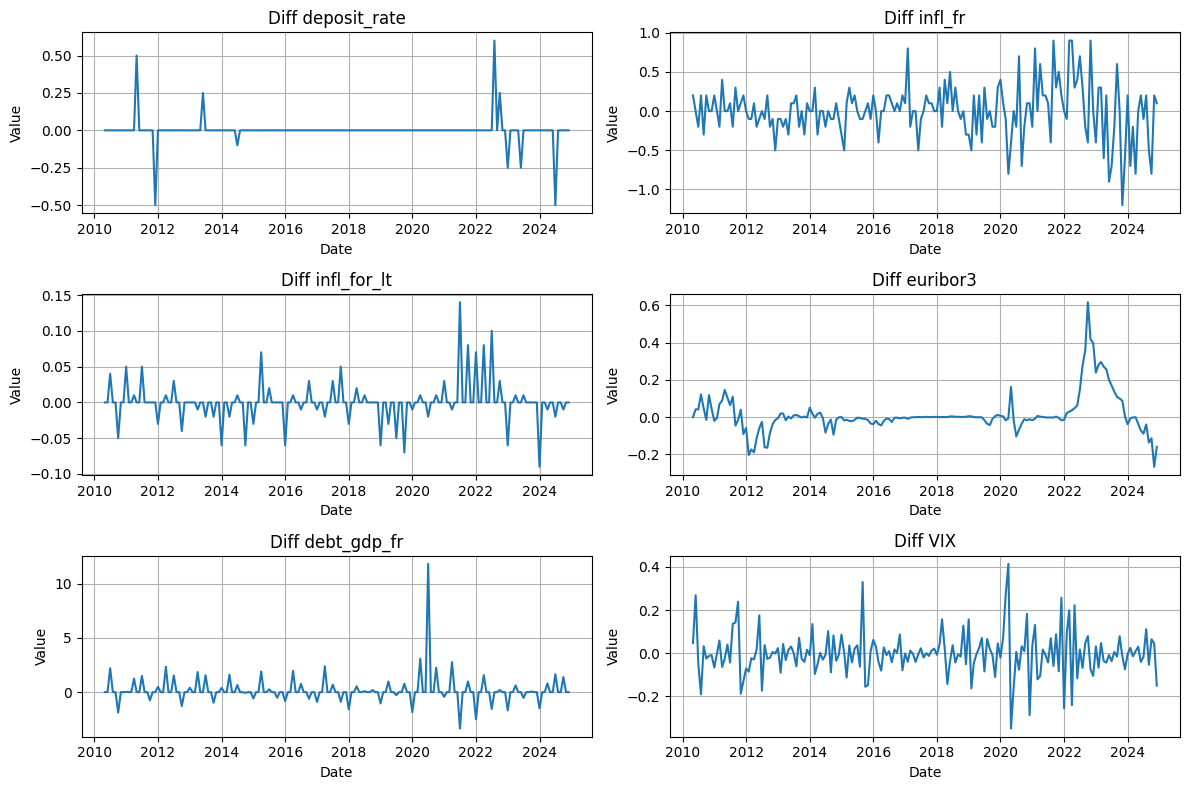

176


In [223]:
# Différencier toutes les colonnes
combined_controls_diff = combined_controls.diff().dropna()

# Conduct a test of stationarity on each control variable after differencing
for column in combined_controls_diff.columns:
    print(f"Testing stationarity for {column} after differencing:")
    result = adfuller(combined_controls_diff[column])
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)

# Plot the control variables after differencing
plt.figure(figsize=(12, 8))
for i, column in enumerate(combined_controls_diff.columns, 1):
    plt.subplot((len(combined_controls_diff.columns) + 1) // 2, 2, i)
    plt.plot(combined_controls_diff[column])
    plt.title(f"Diff {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
plt.tight_layout()
plt.show()

print(len(combined_controls_diff.index))


In [224]:
#On vérifie ensuite si les variables macro  sont autocorrélés:
for column in combined_controls_diff.columns:
    autocorr = combined_controls_diff[column].autocorr()
    print(f"{column}: {autocorr}")

deposit_rate: 0.0
infl_fr: 0.10680342126614764
infl_for_lt: -0.0005113781641523895
euribor3: 0.8669471700567444
debt_gdp_fr: -0.017636849148650283
VIX: -0.23906787703849305


In [225]:
#on produit enfin une table qui résume les données de combind_controls_diff en indiquant leur autocorrélation et leurs statistique de Dickey Fuller:
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
# Compute summary statistics
summary_combined_controls_diff = combined_controls_diff.copy()
summary_stats_controlsdiff = summary_combined_controls_diff.describe().T

# Add autocorrelation column
summary_stats_controlsdiff['autocorrelation'] = summary_combined_controls_diff.apply(
    lambda col: col.autocorr() if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Add Dickey-Fuller test p-value column
summary_stats_controlsdiff['dickey_fuller_pvalue'] = summary_combined_controls_diff.apply(
    lambda col: adfuller(col)[1] if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Format for markdown or text reports
formatted_table_controlsdiff = tabulate(summary_stats_controlsdiff, headers="keys", tablefmt="github")

print(summary_stats_controlsdiff.to_latex(index=True, float_format="%.3f", caption="Summary Statistics with Autocorrelation and Dickey-Fuller Test"))

\begin{table}
\caption{Summary Statistics with Autocorrelation and Dickey-Fuller Test}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max & autocorrelation & dickey_fuller_pvalue \\
\midrule
deposit_rate & 176.000 & 0.000 & 0.088 & -0.500 & 0.000 & 0.000 & 0.000 & 0.600 & 0.000 & 0.000 \\
infl_fr & 176.000 & -0.000 & 0.336 & -1.200 & -0.200 & 0.000 & 0.200 & 0.900 & 0.107 & 0.006 \\
infl_for_lt & 176.000 & 0.001 & 0.025 & -0.090 & 0.000 & 0.000 & 0.000 & 0.140 & -0.001 & 0.000 \\
euribor3 & 176.000 & 0.013 & 0.105 & -0.267 & -0.018 & -0.002 & 0.010 & 0.616 & 0.867 & 0.057 \\
debt_gdp_fr & 176.000 & 0.158 & 1.200 & -3.357 & 0.000 & 0.000 & 0.000 & 11.838 & -0.018 & 0.000 \\
VIX & 176.000 & -0.000 & 0.102 & -0.348 & -0.044 & -0.004 & 0.037 & 0.414 & -0.239 & 0.000 \\
\bottomrule
\end{tabular}
\end{table}



### Régression naïve

In [226]:
date_range = combined_controls.index
mindate=date_range[0]
maxdate=date_range[-1]
print("Date range:")
print("Min date:", mindate)
print("Max date:", maxdate)

Date range:
Min date: 2010-04-01 00:00:00
Max date: 2024-12-01 00:00:00


In [227]:
#from now on, data used for the regression is copied and has format regdata_

In [228]:
##factors (dependent)

regdata_factors = data_factors_mensuel.copy()
regdata_factors.dropna(inplace=True)
regdata_factors = regdata_factors[regdata_factors.index >= mindate]
regdata_factors = regdata_factors[regdata_factors.index <= maxdate]
print("Regdata factors after dropping NAs:")
print(regdata_factors.index)

##Nick bloom (independent)
regdata_NB = data_NB.copy()
regdata_NB.dropna(inplace=True)
regdata_NB = regdata_NB[regdata_NB.index >= mindate]
regdata_NB = regdata_NB[regdata_NB.index <= maxdate]
print("Regdata NB after dropping NAs:")
print(regdata_NB.index)


Regdata factors after dropping NAs:
DatetimeIndex(['2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01', '2011-01-01',
               ...
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='Date', length=174, freq='MS')
Regdata NB after dropping NAs:
DatetimeIndex(['2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01', '2011-01-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Date', length=177, freq=None)


In [229]:
## generate single dataframe for the regression

regdata_all= pd.concat([regdata_factors, regdata_NB, combined_controls.copy()], axis=1)
print(regdata_all.tail())

            factor 1  factor 2  factor 3  factor 4  factor 5  factor 6  \
2024-08-01  4.546607  2.639352  0.767067  2.536274  3.120089  0.135402   
2024-09-01  4.501740  2.492665  0.623039  2.614685  3.056187 -0.034769   
2024-10-01       NaN       NaN       NaN       NaN       NaN       NaN   
2024-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2024-12-01       NaN       NaN       NaN       NaN       NaN       NaN   

            factor 7  factor 8  factor 9  factor 10  ... Italy_News_Index  \
2024-08-01  3.638425  3.843077 -2.441627   6.911583  ...        70.598771   
2024-09-01  3.757865  3.781002 -2.674053   7.160907  ...       110.579817   
2024-10-01       NaN       NaN       NaN        NaN  ...       100.498001   
2024-11-01       NaN       NaN       NaN        NaN  ...       124.806529   
2024-12-01       NaN       NaN       NaN        NaN  ...       133.739942   

            UK_News_Index  France_News_Index  Spain_News_Index  deposit_rate  \
2024-08-01  

In [230]:
### FOnction de régression simple:

import statsmodels.api as sm




def simple_regression(data, factor: int,  controls, lagged=True):

    dependent = f"factor {factor+1}"
    independent = ["France_News_Index"]

    
    independent += controls

    

    # Define X1 and Y1 with the lagged term included
    X = data[independent].to_numpy(dtype=float)

    Y = data[dependent].to_numpy(dtype=float)

    # Fit the model using statsmodels to get t-values
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(Y, X).fit()
    explanatory_vars = ['const'] + independent  # Include constant and explanatory variable names
    model_summary = model.summary(xname=explanatory_vars)  # Use xname to set variable names
    print(f"#######################  Regression for factor {factor+1}: #######################")
    print(model_summary)


restricted_controls=["infl_fr","infl_for_lt","debt_gdp_fr"]
full_controls=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr"]

for i in range(10):
    simple_regression(regdata_all,i, restricted_controls, lagged=False)


#######################  Regression for factor 1: #######################
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 18 Apr 2025   Prob (F-statistic):                nan
Time:                        22:33:34   Log-Likelihood:                    nan
No. Observations:                 177   AIC:                               nan
Df Residuals:                     172   BIC:                               nan
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [231]:
def plot_all_variables(data, features_to_plot):
    """
    Plots all the variables in the provided DataFrame.

    Parameters:
    - data: DataFrame containing the data to plot.
    - features_to_plot: List of column names to plot.
    """
    for feature in features_to_plot:
        if feature in data.columns:
            plt.figure(figsize=(10, 5))
            plt.plot(data.index, data[feature], label=feature)
            plt.title(f"Time Series of {feature}")
            plt.xlabel("Date")
            plt.ylabel(feature)
            plt.legend()
            plt.grid()
            plt.show()

list_features_to_plot=[f"factor {i+1}" for i in range(10)] + ["Deposit-rate", "France_News_Index", " infl_fr", "infl_for_lt", "euribor3", "debt_gdp_fr"]
# Plot all variables in the DataFrame
#plot_all_variables(regdata_all, list_features_to_plot)





### Régressions sur diff premières

Ici, on effectue des régressions en utilisant les données différenciées, ce qui doit permettre d'obtenir des coefs non biaisés

In [232]:
#on commence par récupérer les dates de la régression:
date_range_diff = combined_controls_diff.index
date_range_diff_factors = data_factors_diff.index
mindate_diff = max(date_range_diff[0], date_range_diff_factors[0])
maxdate_diff = min(date_range_diff[-1], date_range_diff_factors[-1])
print("Date range:")
print("Min date:", mindate_diff)
print("Max date:", maxdate_diff)

Date range:
Min date: 2010-05-01 00:00:00
Max date: 2024-09-01 00:00:00


In [233]:
#on choisit ensuite les variables à utiliser pour la régression:

##factors (dependent)

regdata_factors_diff = data_factors_diff.copy()
regdata_factors_diff.dropna(inplace=True)
regdata_factors_diff = regdata_factors_diff[regdata_factors_diff.index >= mindate_diff]
regdata_factors_diff = regdata_factors_diff[regdata_factors_diff.index <= maxdate_diff]
print("Regdata factors after dropping NAs:")
print(regdata_factors_diff.index)

##Nick bloom (independent).
regdata_NB_diff = data_NB_FR.copy()
regdata_NB_diff.dropna(inplace=True)
regdata_NB_diff = regdata_NB_diff[regdata_NB_diff.index >= mindate_diff]
regdata_NB_diff = regdata_NB_diff[regdata_NB_diff.index <= maxdate_diff]
print("Regdata NB after dropping NAs:")

#on normalise par 100  pour que les valeurs du même ordre de grandeur que les facteurs:
regdata_NB_diff.iloc[:,:] = regdata_NB_diff.iloc[:,:] /100

print(regdata_NB_diff.index)


Regdata factors after dropping NAs:
DatetimeIndex(['2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01',
               '2011-01-01', '2011-02-01',
               ...
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='Date', length=173, freq='MS')
Regdata NB after dropping NAs:
DatetimeIndex(['2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01',
               '2011-01-01', '2011-02-01',
               ...
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='Date', length=173, freq=None)


In [234]:
## Comme précédemment, on concatène nos données prêtes pour la régression
## On remarque ici des grandes différences de niveau entre la mesure de l'incertitude de Nick Bloom et les variables différenciées, ce qui rend l'interprétation plus difficile.
regdata_all_diff= pd.concat([regdata_factors_diff, regdata_NB_diff, combined_controls_diff.copy()], axis=1)
regdata_all_diff.dropna(inplace=True)

print(regdata_all_diff.columns)

Index(['factor 1', 'factor 2', 'factor 3', 'factor 4', 'factor 5', 'factor 6',
       'factor 7', 'factor 8', 'factor 9', 'factor 10', 'France_News_Index',
       'European_News_Index', 'deposit_rate', 'infl_fr', 'infl_for_lt',
       'euribor3', 'debt_gdp_fr', 'VIX'],
      dtype='object')


Maintenant que nos données sont prêtes, on les visualise une dernière fois avant de régresser


In [235]:
regdata_all_diff

,factor 1,factor 2,factor 3,factor 4,factor 5,factor 6,factor 7,factor 8,factor 9,factor 10,France_News_Index,European_News_Index,deposit_rate,infl_fr,infl_for_lt,euribor3,debt_gdp_fr,VIX
2010-05-01,0.115342,-0.035125,-0.549231,-0.514908,0.112919,-0.378578,-0.000717,-0.120213,-0.408928,0.441725,3.682284,2.033052,0.0,0.2,0.00,-0.0003,0.000,0.047669
2010-06-01,-0.265308,-0.095860,0.246973,-0.118887,-0.229931,0.105809,-0.090296,0.211286,0.787797,0.055953,1.354589,1.714027,0.0,0.0,0.00,0.0418,0.000,0.269015
2010-07-01,0.074170,0.307933,0.405491,-0.208736,-0.652174,-0.097996,0.210233,-0.587012,-0.124333,-0.140422,1.871168,1.865552,0.0,-0.2,0.04,0.0411,2.211,-0.046968
2010-08-01,0.146988,0.055995,0.000083,0.267118,0.004930,-0.470402,0.069188,-0.127853,0.399892,0.361369,1.707781,1.728161,0.0,0.2,0.00,0.1212,0.000,-0.190151
2010-09-01,-0.114421,0.040795,-0.205701,-0.780448,-0.075901,0.133046,-0.562158,-0.541651,0.319190,-0.080359,2.145264,1.616901,0.0,-0.3,0.00,0.0467,0.000,0.032948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,-0.268241,0.102705,0.511008,0.138989,0.031411,-0.004006,0.011145,-0.177274,-0.289199,0.149924,3.044463,2.908353,0.0,0.0,0.00,-0.0360,0.000,0.030494
2024-06-01,-0.166556,-0.083011,0.137518,0.037622,-0.235813,-0.025953,-0.066671,-0.413111,0.154158,0.755857,4.092721,3.275063,0.0,0.2,0.00,-0.0727,0.000,-0.039958
2024-07-01,0.013709,-0.018068,-0.007936,0.178312,0.177301,0.205665,0.406816,0.136846,-0.343472,-0.094956,5.439326,3.618538,-0.5,-0.1,-0.02,-0.0892,1.649,-0.015598
2024-08-01,-0.073324,-0.583686,-0.921981,-0.269004,-0.056204,-0.262324,-0.011379,-0.059835,-0.149932,0.317627,3.707855,2.634282,0.0,0.2,0.00,-0.0397,0.000,0.111637


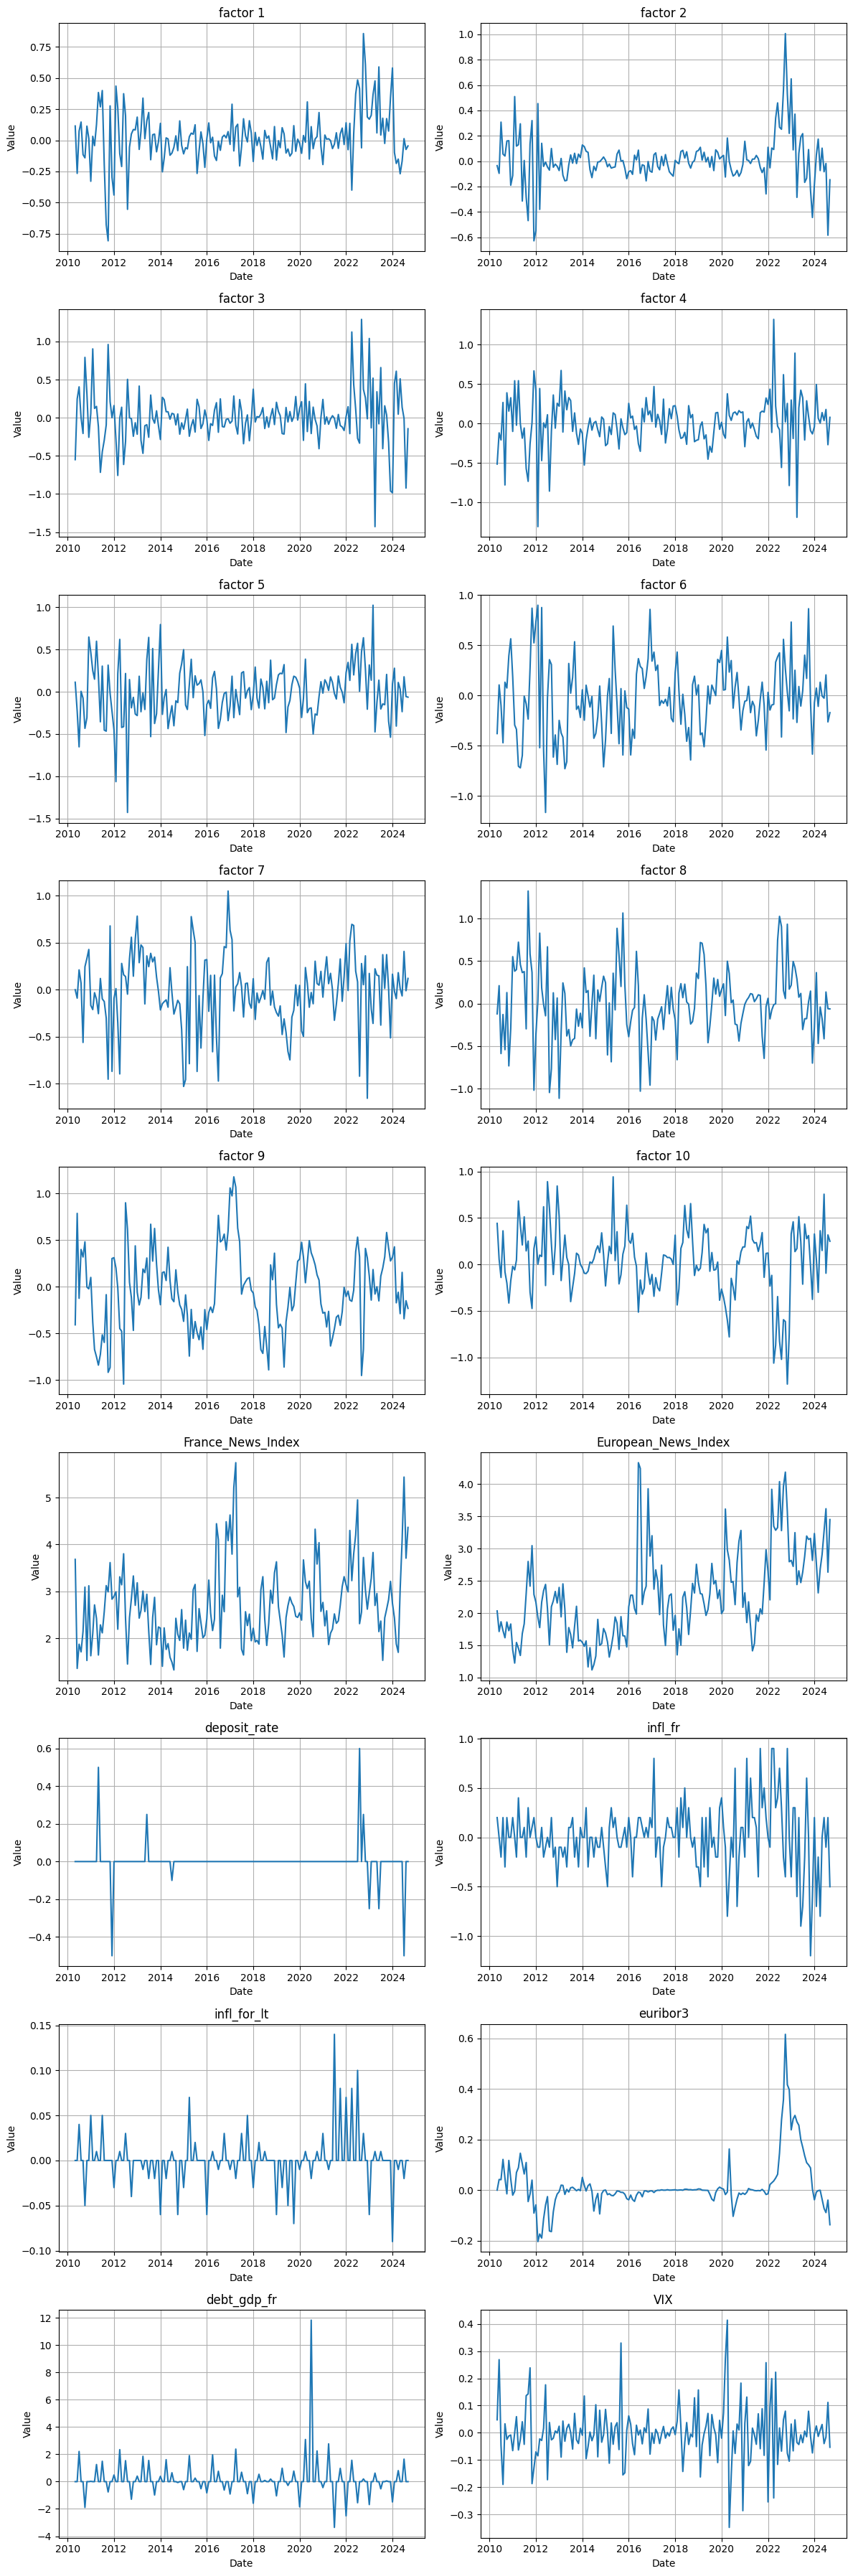

In [236]:
# Plot the data used for the regression
num_columns = len(regdata_all_diff.columns)
num_rows = (num_columns + 1) // 2  # Calculate the number of rows needed for 2 columns per row

plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure height based on the number of rows
for i, column in enumerate(regdata_all_diff.columns, 1):
    plt.subplot(num_rows, 2, i)
    plt.plot(regdata_all_diff[column])
    plt.title(str(column))
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
plt.tight_layout()
plt.show()

On étudie enfin les corrélations entre les variables de régression:
- d'abord les facteurs
- ensuite les contrôles pour identifier les contrôles redondants
- enfin le total

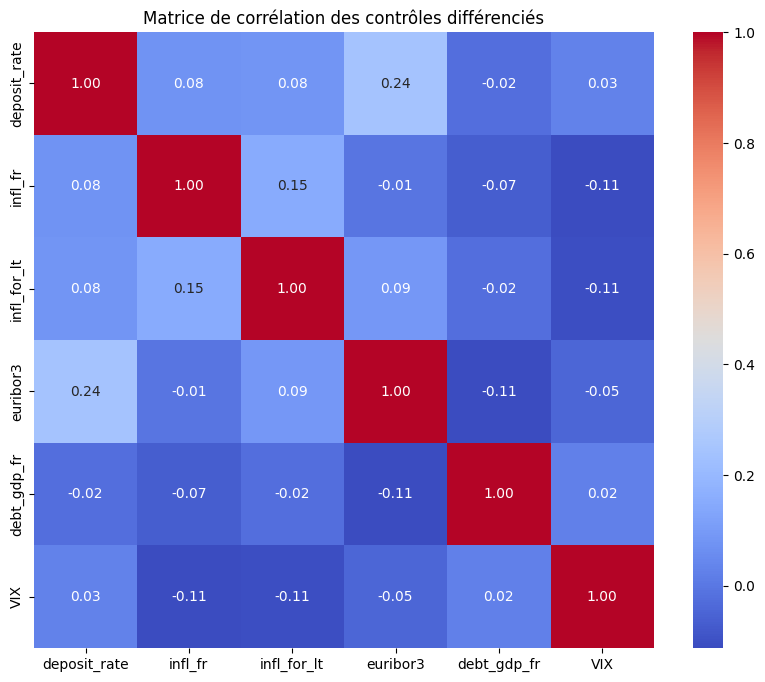

In [246]:
#on s'intéresse  aux correlations entre les contrôles pour limiter la multicolinéarité:

import seaborn as sns
# Calculate the cross-correlation matrix
correlation_matrix_regdiff = regdata_all_diff.copy()[["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr", "VIX"]].corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_regdiff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des contrôles différenciés")
plt.show()

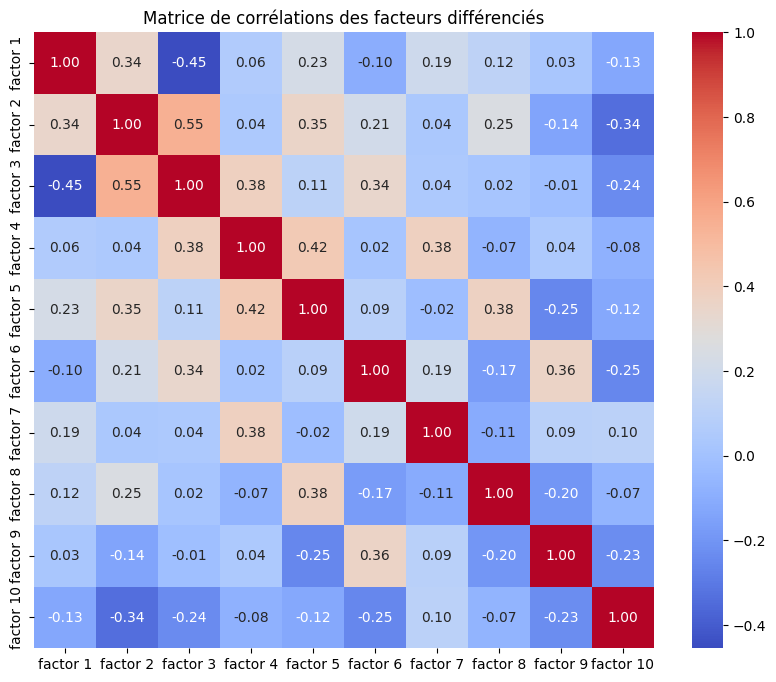

In [247]:
import seaborn as sns
# Calculate the cross-correlation matrix
correlation_matrix_regdiff = regdata_all_diff.copy()[[f"factor {i}" for i in range(1,11)]].corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_regdiff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélations des facteurs différenciés")
plt.show()

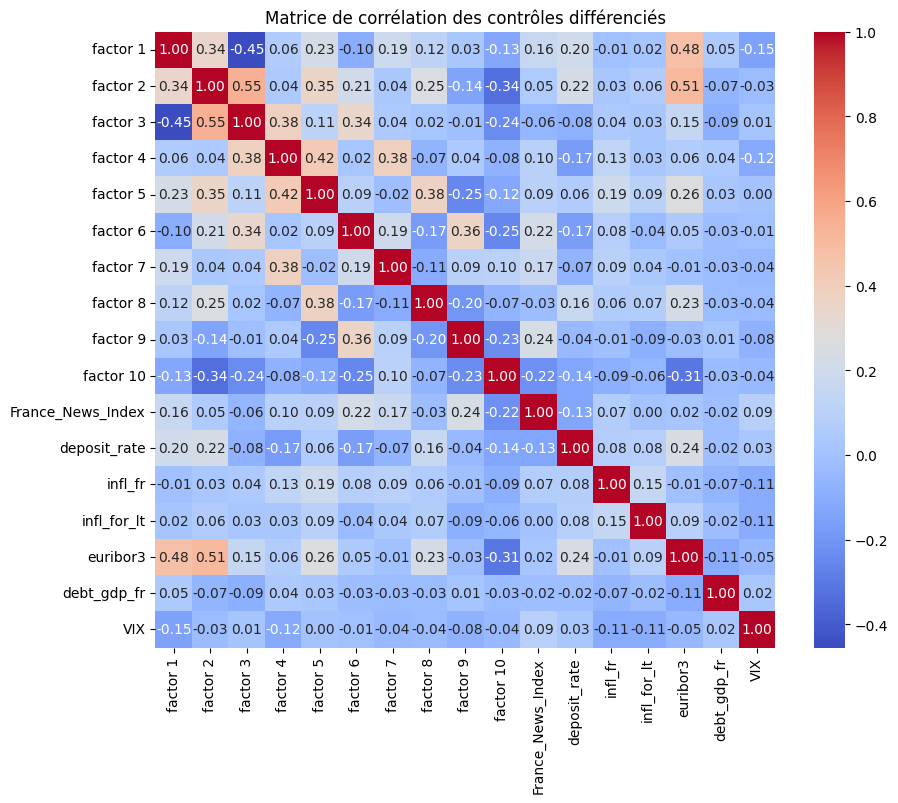

In [248]:
#on s'intéresse  aux correlations entre les contrôles pour limiter la multicolinéarité:

import seaborn as sns
# Calculate the cross-correlation matrix
corr_allvar = regdata_all_diff.copy().drop(["European_News_Index"], axis=1)
correlation_matrix_regdiff = corr_allvar.corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_regdiff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des contrôles différenciés")
plt.show()

In [240]:
## COmparaison VIX et News Index:

On code enfin les différentes régressions:
- d'abord une régression linéaire simple
- ensuite une régression linéaire prenant en compte l'autocorrélation des erreurs

In [249]:
### FOnction de régression simple:

import statsmodels.api as sm

def regression_diff(data, factor: int, independent, controls,robust=False):

    dependent = f"factor {factor+1}"

    indep = independent.copy()
    indep += controls.copy()
    X = data[indep].to_numpy(dtype=float)


    Y = data[dependent].to_numpy(dtype=float)


    # Fit the model using statsmodels to get t-values
    X = sm.add_constant(X)  # Adds a constant term to the predictor


    if robust:
        # Fit the model using HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors
        model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    else:
        model = sm.OLS(Y, X).fit()
    explanatory_vars = ['const'] + indep  # Include constant and explanatory variable names
    model_summary = model.summary(xname=explanatory_vars)  # Use xname to set variable names
    print(f"#######################  Regression for factor {factor+1}: #######################")
    print(model_summary)

    if robust:
        print("Robust standard errors used.")
    else:
        print("Standard errors used.")

    
independent = ["France_News_Index"]
restricted_controls=["infl_fr","debt_gdp_fr", "VIX"]
full_controls=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr", "VIX"]

for i in range(10):
    regression_diff(regdata_all_diff,i, independent, restricted_controls,robust=True,)

#######################  Regression for factor 1: #######################
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.394
Date:                Fri, 18 Apr 2025   Prob (F-statistic):             0.0525
Time:                        22:34:13   Log-Likelihood:                 29.375
No. Observations:                 173   AIC:                            -48.75
Df Residuals:                     168   BIC:                            -32.98
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

On souhaite enfin publier les résultats joliment:

In [252]:
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm

regdata_all_diff_short=regdata_all_diff.copy()
regdata_all_diff_short=regdata_all_diff_short[regdata_all_diff_short.index>=np.datetime64("2017-05-01")]


def run_model(data, y_var, x_vars, robust=False):
    X = data[x_vars]
    X = sm.add_constant(X)
    Y = data[y_var]
    if robust:
        return sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    else:
        return sm.OLS(Y, X).fit()

# Spécifications des variables
indep = ["France_News_Index"]
controls_r = ["infl_fr", "infl_for_lt", "debt_gdp_fr", "VIX"]
controls_f = ["deposit_rate", "infl_fr", "infl_for_lt", "euribor3", "debt_gdp_fr", "VIX"]
controls_signif=["infl_fr", "euribor3", "VIX"]
last=["euribor3"]
last2=["infl_fr", "euribor3","VIX"]

# Boucle sur tous les facteurs
models = []
model_names = []

for i in range(10):
    y = f"factor {i+1}"

    model1 = run_model(regdata_all, y, indep, robust=False)
    model2 = run_model(regdata_all, y, indep + controls_f, robust=False)
    model3 = run_model(regdata_all_diff, y, indep, robust=True)
    model4 = run_model(regdata_all_diff, y, indep + controls_f, robust=True)
    model5 = run_model(regdata_all_diff, y, indep + controls_r, robust=True)
    model6 = run_model(regdata_all_diff, y, indep + controls_signif, robust=True)
    model7 = run_model(regdata_all_diff_short, y, indep + controls_f, robust=True)
    model8=run_model(regdata_all_diff_short, y, indep + last, robust=True)
    model9=run_model(regdata_all, y, indep + last2, robust=True)

    #choix du modèle présenté
    models.append(model6)
    model_names.append(f"Facteur {i+1}")

# Création du tableau LaTeX avec 10 colonnes (un facteur par colonne, spécification 5 ici)
results_table = summary_col(models,
                            stars=True,
                            float_format='%0.3f',
                            model_names=model_names,
                            info_dict={'R²': lambda x: f"{x.rsquared:.2f}",
                                       'N': lambda x: f"{int(x.nobs)}"})

# Export LaTeX
with open("table_regdiff_6.tex", "w") as f:
    f.write(results_table.as_latex())


In [243]:
### On essaie enfin de faire les régressions sur une période plus courte, depuis le 1er mandat Macron:

regdata_all_diff_short=regdata_all_diff.copy()
regdata_all_diff_short=regdata_all_diff_short[regdata_all_diff_short.index>=np.datetime64("2017-05-01")]
    
independent = ["France_News_Index"]
restricted_controls=["infl_fr","infl_for_lt","debt_gdp_fr", "VIX"]
full_controls=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr", "VIX"]

print("Période: à partir du 1er mai 2017")
for i in range(10):
    regression_diff(regdata_all_diff_short,i, independent, full_controls,robust=True,)


Période: à partir du 1er mai 2017
#######################  Regression for factor 1: #######################
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     12.88
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           5.14e-11
Time:                        22:33:38   Log-Likelihood:                 39.642
No. Observations:                  89   AIC:                            -63.28
Df Residuals:                      81   BIC:                            -43.37
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------

### Tests de l'impact dévénements

Chow test, Bai-Perron...

In [244]:
#on code une listd d'événements dont on souhaite étudier l'éffet sur nos séries

events_names=["COVID-19", "Ukraine War", "Brexit", "Trump Election", "Eurozone Crisis", "Greece Crisis 2", "Macron election 1", "Macron élection 2", "Dissolution", "Gilets Jaunes"]
events_dates=["2020-03-01", "2022-02-01", "2016-06-01", "2016-11-01", "2011-07-01", "2015-07-01", "2017-05-01", "2022-06-01", "2023-07-01", "2018-11-01"]
events_dates = pd.to_datetime(events_dates)
events_series = pd.Series(events_dates, index=events_names)

dates_regdata_all_diff= regdata_all_diff.index
dates_regdata_all_diff = pd.to_datetime(dates_regdata_all_diff)
dummys_events= pd.DataFrame(index=dates_regdata_all_diff, columns=events_names)

regdata_all_diff_dummys = regdata_all_diff.copy()


for i, col in enumerate(dummys_events.columns):
    dummys_events[col] = 0
    #all dates before the event are set to 0
    
    #all dates after the event are set to 1
    dummys_events.loc[events_series[col]<=dummys_events.index, col] = 1

    regdata_all_diff_dummys=pd.concat([regdata_all_diff_dummys, dummys_events], axis=1)



#on ajoute les variables dummies à nos données de régression
regdata_all_diff_dummys = pd.concat([regdata_all_diff.copy(), dummys_events])

controls_events=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr", "VIX"]+events_names
independent = ["France_News_Index"]

regdata_all_diff_dummys.tail()

,factor 1,factor 2,factor 3,factor 4,factor 5,factor 6,factor 7,factor 8,factor 9,factor 10,...,COVID-19,Ukraine War,Brexit,Trump Election,Eurozone Crisis,Greece Crisis 2,Macron election 1,Macron élection 2,Dissolution,Gilets Jaunes
2024-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [245]:
for i in range(10):
    regression_diff(regdata_all_diff_dummys,i, independent, controls_events,robust=True,)


MissingDataError: exog contains inf or nans

### Statistiques descriptives (avant diff-diff)

In [ ]:
from tabulate import tabulate


In [ ]:
## Summary statistics of regression variables

data_summary = regdata_all.copy()


# Compute summary statistics
summary_stats = data_summary.describe().T

# Format for markdown or text reports
formatted_table = tabulate(summary_stats, headers="keys", tablefmt="github")

print(summary_stats.to_latex(index=True, float_format="%.3f", caption="Summary Statistics"))


\begin{table}
\caption{Summary Statistics}
\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
factor 1 & 173.000 & 0.398 & 1.552 & -0.791 & -0.458 & -0.192 & 0.364 & 5.317 \\
factor 2 & 173.000 & 0.375 & 1.378 & -1.069 & -0.639 & -0.061 & 0.602 & 4.070 \\
factor 3 & 173.000 & -0.064 & 1.123 & -1.484 & -0.979 & -0.449 & 0.722 & 2.661 \\
factor 4 & 173.000 & 0.395 & 1.085 & -1.628 & -0.474 & 0.346 & 1.273 & 2.747 \\
factor 5 & 173.000 & 1.477 & 1.684 & -1.018 & -0.006 & 1.023 & 3.076 & 5.099 \\
factor 6 & 173.000 & -0.193 & 2.042 & -3.824 & -1.661 & -0.527 & 0.482 & 4.923 \\
factor 7 & 173.000 & 4.313 & 1.929 & 0.619 & 3.074 & 4.305 & 5.724 & 8.359 \\
factor 8 & 173.000 & 1.738 & 2.031 & -1.957 & 0.401 & 1.398 & 3.181 & 5.888 \\
factor 9 & 173.000 & -0.525 & 2.754 & -4.948 & -2.682 & -0.618 & 1.298 & 5.585 \\
factor 10 & 173.000 & 6.900 & 2.657 & 0.909 & 5.530 & 7.294 & 8.893 & 11.152 \\
Month & 173.000 & 6.514 & 3.421 & 1.000 & 4.000 & 7.

In [ ]:
## plot nice tables for full data:

list_BCE_data_copy_tables = [data.copy() for data in list_BCE_data]
#list_BCE_data_copy_tables.append(data_NB.copy())
list_BCE_data_copy_tables.append(data_factors.copy())
data_summary = pd.concat(list_BCE_data_copy_tables, axis=1)
data_summary=data_summary[data_summary.index>=np.datetime64("2009-12-01")]

#data_summary.drop(["Germany_News_Index", "Italy_News_Index", "Spain_News_Index", "UK_News_Index"],axis=1, inplace=True)


# Compute summary statistics
summary_stats = data_summary.describe().T

# Add columns for minimum and maximum dates for each data
summary_stats['min_date'] = data_summary.apply(lambda col: col.dropna().index.min().date() if col.dropna().index.is_unique else None, axis=0)
summary_stats['max_date'] = data_summary.apply(lambda col: col.dropna().index.max().date() if col.dropna().index.is_unique else None, axis=0)

# Add a frequency column
summary_stats['frequency'] = data_summary.apply(lambda col: col.dropna().index.freqstr if col.dropna().index.freq else 'Unknown', axis=0)


# Add autocorrelation column
summary_stats['autocorrelation'] = data_summary.apply(
    lambda col: col[~data_summary.duplicated()].dropna().autocorr() if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Format for markdown or text reports
formatted_table = tabulate(summary_stats, headers="keys", tablefmt="github")


print(summary_stats.to_latex(index=True, float_format="%.3f", caption="Summary Statistics with Min, Max Dates, and Frequency"))






\begin{table}
\caption{Summary Statistics with Min, Max Dates, and Frequency}
\begin{tabular}{lrrrrrrrrlllr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max & min_date & max_date & frequency & autocorrelation \\
\midrule
deposit_rate & 5588.000 & -0.055 & 0.206 & -0.250 & -0.100 & -0.100 & -0.100 & 0.750 & 2009-12-01 & 2025-03-19 & Unknown & 0.983 \\
infl_fr & 183.000 & 1.944 & 1.756 & -0.400 & 0.800 & 1.600 & 2.400 & 7.300 & 2009-12-31 & 2025-02-28 & Unknown & 0.981 \\
infl_for_lt & 62.000 & 1.900 & 0.132 & 1.650 & 1.820 & 1.890 & 1.988 & 2.180 & 2009-12-31 & 2025-03-31 & Unknown & 0.948 \\
euribor3 & 183.000 & 0.576 & 1.314 & -0.582 & -0.329 & 0.081 & 1.004 & 3.972 & 2009-12-31 & 2025-02-28 & Unknown & 0.997 \\
debt_gdp_fr & 60.000 & 100.574 & 9.354 & 84.056 & 94.461 & 99.011 & 111.344 & 117.687 & 2009-12-31 & 2024-09-30 & Unknown & 0.975 \\
factor 1 & 772.000 & 0.386 & 1.515 & -0.936 & -0.456 & -0.174 & 0.400 & 5.705 & 2009-12-02 & 2024-09-11 & Unknown & 0.998 \\
factor

In [ ]:
for data in list_BCE_data:
    print(data.head())

            deposit_rate
Date                    
1999-01-01           NaN
1999-01-04          0.75
1999-01-05          0.75
1999-01-06          0.75
1999-01-07          0.75
            infl_fr
Date               
1997-01-31      1.8
1997-02-28      1.7
1997-03-31      1.1
1997-04-30      1.0
1997-05-31      0.9
            infl_for_lt
Date                   
1999-03-31         1.86
2000-03-31         1.77
2001-03-31         1.81
2001-06-30         1.80
2001-09-30         1.81
            euribor3
Date                
1994-01-31      6.91
1994-02-28      6.86
1994-03-31      6.75
1994-04-30      6.57
1994-05-31      6.24
            debt_gdp_fr
Date                   
1999-03-31       60.228
1999-06-30       59.523
1999-09-30       59.731
1999-12-31       59.062
2000-03-31       60.377


### Présentation résultats régressions